## 1. libraries import and setup

In [1]:
import os
import geopandas as gpd
import rioxarray as rxr
#from rasterio.plot import show
from matplotlib import pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np
import xarray as xr
from shapely.geometry import box
from pathlib import Path
import importlib.util

In [2]:
# load the setup.py module
path = Path.cwd().parent / 'src' / 'setup.py'
spec = importlib.util.spec_from_file_location('setup', path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

# call the make_folders function
raw_data_dir, processed_data_dir, output_dir = setup.make_folders()

created directory data\raw_data\nDSM
created directory data\raw_data\DOP
created directory data\raw_data\gaps_poly
created directory data\processed_data
created directory data\metadata
created directory output


## 2. data reading

In [3]:
# read DOP
dop_path = raw_data_dir / 'DOP' / 'dop_limker-strang_2019.tif'
dop = rxr.open_rasterio(dop_path, band_as_variable = True)
dop

<xarray.Dataset>
Dimensions:      (x: 23554, y: 37587)
Coordinates:
  * x            (x) float64 5.444e+05 5.444e+05 ... 5.488e+05 5.488e+05
  * y            (y) float64 5.734e+06 5.734e+06 ... 5.727e+06 5.727e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) uint16 ...
    band_2       (y, x) uint16 ...
    band_3       (y, x) uint16 ...
    band_4       (y, x) uint16 ...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        E
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [4]:
# read gap polygons
gaps_poly_path = raw_data_dir / 'gaps_poly' / 'limk_19_poly.shp'
gaps_poly = gpd.read_file(gaps_poly_path)
gaps_poly

,ID_1,AREA,N_RAND_14,Perimeter,Bemerkunge,lg_attach,geometry
0,500,47.353,0,0.0,NaN,NaN,"POLYGON Z ((546475.360 5730134.031 432.462, 54..."
1,501,24.406,0,0.0,NaN,NaN,"POLYGON Z ((546448.631 5730152.592 425.877, 54..."
2,502,21.648,0,0.0,NaN,NaN,"POLYGON Z ((546541.299 5730092.363 437.454, 54..."
3,503,34.133,0,0.0,NaN,NaN,"POLYGON Z ((546593.744 5730081.995 440.941, 54..."
4,504,60.527,0,0.0,NaN,NaN,"POLYGON Z ((546638.868 5730097.666 442.477, 54..."
...,...,...,...,...,...,...,...
128,547,85.183,0,0.0,NaN,NaN,"POLYGON Z ((546858.653 5730138.085 448.258, 54..."
129,0,14.945,0,0.0,NaN,NaN,"POLYGON Z ((546586.484 5730122.642 439.045, 54..."
130,0,15.779,0,0.0,NaN,NaN,"POLYGON Z ((546591.152 5730160.001 436.198, 54..."
131,515,374.701,0,0.0,NaN,NaN,"POLYGON Z ((546683.826 5730221.513 435.988, 54..."


<Axes: >

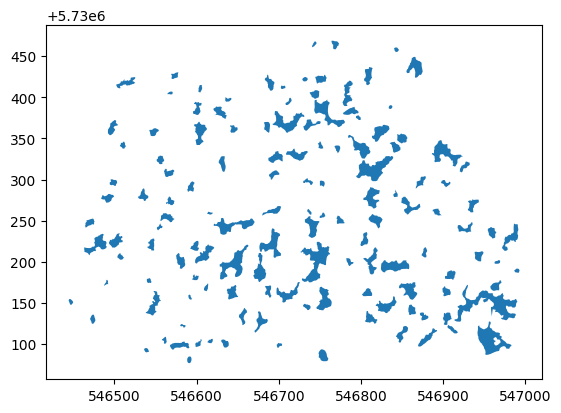

In [5]:
# quick view
gaps_poly.plot()

## 3. data preparation
### 3.1 clipping the DOP to the extent of the canopy gaps layer

In [6]:
# define path to the clipped DOP
dop_clipped_path = processed_data_dir / 'dop_clipped.tif'

# check if dop_clipped.tif already exists
if not dop_clipped_path.exists():
    
    # get bounding box of the gap polygons
    bbox = gaps_poly.total_bounds
    
    # create bounding box polygon
    bbox_poly = box(*bbox)
    
    # clip DOP to the bounding box polygon extent (gaps extent)
    dop_clipped = dop.rio.clip([bbox_poly], dop.rio.crs)
    
    # save clipped DOP
    dop_clipped.rio.to_raster(dop_clipped_path)
    print('Clipped DOP saved.')
    
else:
    
    # load existing clipped DOP
    dop_clipped = rxr.open_rasterio(dop_clipped_path, band_as_variable = True)
    print('Existing clipped DOP loaded.')

Existing clipped DOP loaded.


In [21]:
dop_clipped

<xarray.Dataset>
Dimensions:      (x: 2916, y: 2086)
Coordinates:
  * x            (x) float64 5.464e+05 5.464e+05 5.464e+05 ... 5.47e+05 5.47e+05
  * y            (y) float64 5.73e+06 5.73e+06 5.73e+06 ... 5.73e+06 5.73e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) uint16 ...
    band_2       (y, x) uint16 ...
    band_3       (y, x) uint16 ...
    band_4       (y, x) uint16 ...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        E
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

### 3.2 normalization of the band values for plotting tasks 

In [7]:
# normalize uint16 data to [0, 255]
normalized_bands = (dop_clipped - dop_clipped.min()) / (dop_clipped.max() - dop_clipped.min()) * 255

# convert normalized bands to uint8
dop_clipped_norm = normalized_bands.astype(np.uint8)
dop_clipped_norm

<xarray.Dataset>
Dimensions:      (y: 2086, x: 2916)
Coordinates:
  * x            (x) float64 5.464e+05 5.464e+05 5.464e+05 ... 5.47e+05 5.47e+05
  * y            (y) float64 5.73e+06 5.73e+06 5.73e+06 ... 5.73e+06 5.73e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) uint8 39 51 66 67 60 55 59 60 ... 41 51 54 53 46 41 51
    band_2       (y, x) uint8 36 53 74 73 64 58 64 67 ... 42 54 58 55 44 35 47
    band_3       (y, x) uint8 54 75 101 101 88 81 88 91 ... 73 88 92 89 74 62 75
    band_4       (y, x) uint8 105 118 134 132 121 115 118 ... 48 49 45 35 28 35

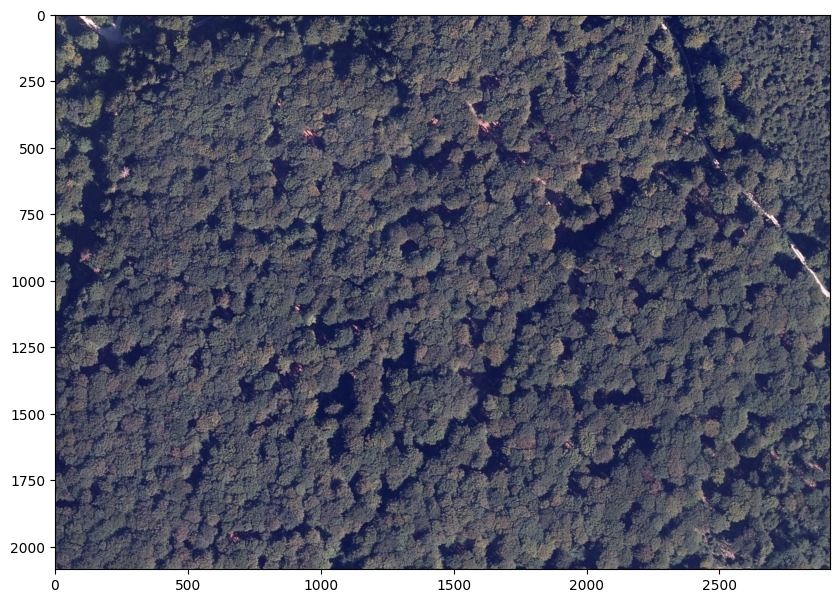

In [8]:
# plot of the clipped DOP
plt.figure(figsize=(10, 8))
plt.imshow(np.array([dop_clipped_norm.band_1, dop_clipped_norm.band_2, dop_clipped_norm.band_3]).transpose(1,2,0))
plt.show()

### testing...

In [13]:
#src = rasterio.open(dop_path)
#src

In [14]:
#src.profile

In [11]:
#dop_path = raw_data_dir + 'DOP/dop_limker-strang_2019.tif'

#with rasterio.open(dop_path) as src:
#    red = src.read(1)
#    green = src.read(2)
#    blue = src.read(3)
#    nir = src.read(4)

In [18]:
# stack the color bands to create a true-color image (RGB)
#rgb_image = [red, green, blue]
#rgb_image = [band.astype('float64') / 255.0 for band in rgb_image]
#rgb_image = np.stack(rgb_image, axis=-1)

In [ ]:
# plot the true-color (RGB) image
#plt.figure(figsize=(10, 8))
#plt.imshow(rgb_image)
#plt.show()